In [55]:
import opensimplex
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint
from matplotlib.colors import ListedColormap
import os

In [66]:
class generator:
    BIOMAS = {
        0: ([0.2, 0.2, 0.4], "Desierto", "#ffd31d"),
        1: ([0.35, 0.85, 0.35], "Montaña", "#7d7d7d"),
        2: ([0.4, 0.2, 0.35], "Valle", "#90db94"),
        3: ([0.5, 0.2, 0.55], "Bosque", "#35762b"),
        4: ([0.6, 0.2, 0.6], "Selva", "#00b70a"),
        5: ([0.1, 0.2, 0.7], "Savana", "#e47d1c"),
        6: ([0.2, 0.65, 0.55], "Meseta", "#6e5842"),
        7: ([0.5, 0.1, 0.5], "Costa", "#f5f06c"),
        8: ([0.75, 0.25, 0.75], "Termales", "#279c79"),
        9: ([0.35, 0.2, 0.55], "Dehesa", "#80b31e"),
        10: ([0.15, 0.8, 0.85], "Volcanico", "#9f1010"),
        11: ([0.85, 0.05, 0.45], "Marismas", "#abde20"),
        12: ([0.8, 0.15, 0.45], "Pantano", "#218563"),
        13: ([0.65, 0.75, 0.3], "Tundra", "#d0d0f0"), 
        14: ([0.75, 0.1, 0.05], "Polo", "#fafafa"),
        15: ([-1, -1, -1], "Oceano", "#3894c2"),
        16: ([-1, -1, -1], "Oceano profundo", "#1b3b8c"),
        17: ([-1, -1, -1], "Rios y lagos", "#7eb4ed")
    }
    CHUNK_SIZE = 128
    CERCANIA_BIOMAS = np.load("./CERCANIA_BIOMAS.npy", allow_pickle=True)

    def __init__(self, seedTemp = None, seedAltu = None, seedHume = None):
        self.SEEDTEMP = seedTemp if seedTemp != None else randint(-2**30, 2**30)
        self.SEEDALTU = seedAltu if seedTemp != None else randint(-2**30, 2**30)
        self.SEEDHUME = seedHume if seedTemp != None else randint(-2**30, 2**30)

    def getNoise(self, seed: int, x_in: int, y_in: int, iterations: int, size: int):
        """
        Generates Perlin noise using OpenSimplex.

        Args:
            seed (int): Random seed for OpenSimplex.
            x_in (float): X coordinate of the noise point.
            y_in (float): Y coordinate of the noise point.
            iterations (int): Number of noise octaves.

        Returns:
            np.ndarray: 2D array of Perlin noise values.
        """

        x = self.CHUNK_SIZE*x_in
        y = self.CHUNK_SIZE*y_in
        opensimplex.seed(seed)

        rango = range(0,self.CHUNK_SIZE)
        noise_array = np.zeros(dtype=float, shape=(self.CHUNK_SIZE, self.CHUNK_SIZE))

        for r in range(iterations):
            divisor = (size/2**r)
            exponenciador = (2**r)
            for i in rango:
                for j in rango:
                    noise_array[j, i] += opensimplex.noise2(x=(i+x)/divisor, y=(y+j)/divisor)/exponenciador
        
        maximo = sum([2/(2**r) for r in range(iterations)])
        for i in rango:
            for j in rango:
                valor = (noise_array[j, i] + maximo)/(2*maximo)     
                for r in range(3):
                    noise_array[j, i] = 0.5 + math.sin(math.pi*valor - math.pi/2)/2

        return noise_array
    
    def getBioma(self, temp, altu, hume):
        if(altu < 0.5):
            if (altu <= 0.45):
                return 15 #Oceano
            else:
                return 16 #Oceano profundo
        else:
            alt = math.floor(64*altu)
            temp = math.floor(64*temp)
            hum = math.floor(64*hume)
            return self.CERCANIA_BIOMAS[hum, alt, temp]
    
    def getChunk(self, x, y):
        """
        Generates a 2D array of Perlin noise values for a chunk.

        Args:
            x (int): X coordinate of the chunk.
            y (int): Y coordinate of the chunk.

        Returns:
            np.ndarray: 2D array of Perlin noise values.
        """

        if os.path.exists(f"./Chunks/{x}/{y}.npy"):
            return np.load(f"./Chunks/{x}/{y}.npy")
        else:
            temp = self.getNoise(self.SEEDTEMP, x, y, 6, 256)
            altu = self.getNoise(self.SEEDALTU, x, y, 4, 512)
            hume = self.getNoise(self.SEEDHUME, x, y, 4, 512)
            array_biomas = np.zeros(dtype=np.uint8, shape=(self.CHUNK_SIZE,self.CHUNK_SIZE))
            for i in range(self.CHUNK_SIZE):
                for j in range(self.CHUNK_SIZE):
                    array_biomas[i, j] = self.getBioma(temp[i, j], altu[i, j], hume[i, j])
            os.makedirs(f"./Chunks/{x}", exist_ok=True)
            np.save(f"./Chunks/{x}/{y}", array_biomas)
            return array_biomas
    
    def representation(self, x_range: tuple[int, int], y_range: tuple[int, int]):
        arr = None
        for i in range(x_range[0], x_range[1]):
            arr_line = None
            for j in range(y_range[0], y_range[1]):
                if arr_line is None:
                    arr_line = self.getChunk(i, j)
                else:
                    arr_line = np.vstack((arr_line, self.getChunk(i, j)))
            if arr is None:
                arr = arr_line
            else:
                arr = np.hstack((arr, arr_line))

        fig, ax = plt.subplots(figsize=(20, 20)) 
        # Create the colormap

        cmap = ListedColormap([self.BIOMAS[key][2] for key in self.BIOMAS.keys()])

        # Plot the image using imshow with the specified colormap
        im = ax.imshow(arr, cmap=cmap, interpolation='none')

        # Add a colorbar with custom labels
        cbar = plt.colorbar(im, ticks=list(self.BIOMAS.keys()))  # Set ticks to biome IDs
        cbar.ax.set_yticklabels([f"id {key}:{self.BIOMAS[key][1]}" for key in self.BIOMAS.keys()])  # Set labels to biome names

        # Set the title and labels
        ax.set_title('2D Array with Tab20 Colormap')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')

        # Show the plot
        plt.show()

In [ ]:
a = generator(-1006671994, -648134080,688897970 )

In [72]:
print(a.SEEDALTU, a.SEEDHUME, a.SEEDTEMP)

-648134080 688897970 -1006671994


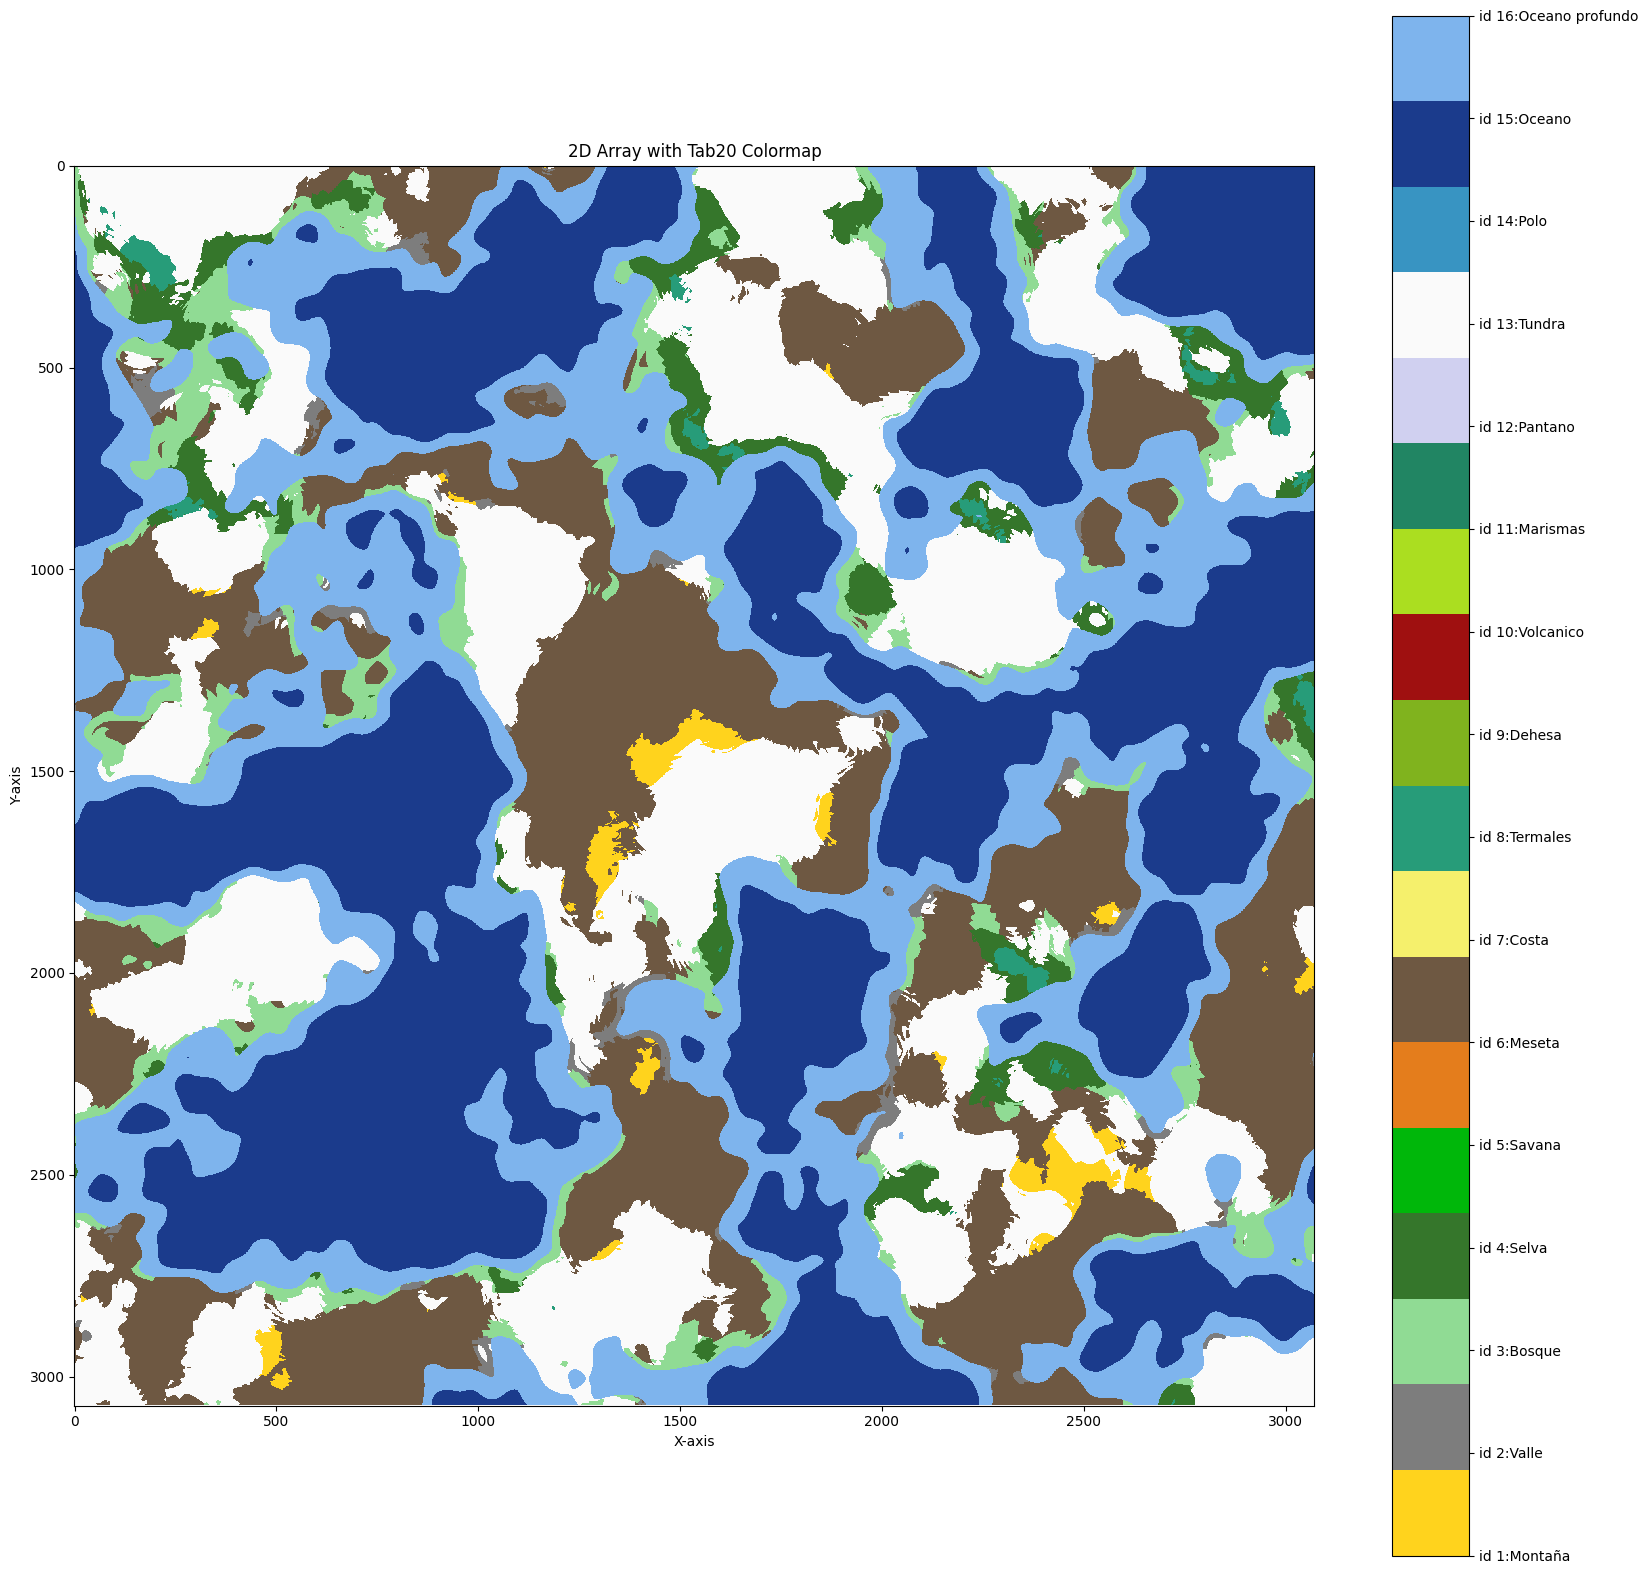

In [73]:
a.representation((0,24),(0,24))